In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error, mean_squared_error, r2_score, precision_score, recall_score, roc_auc_score, log_loss
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, SelectKBest, chi2
from sklearn.ensemble import RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Display the entire matrix when using the display method
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
file_path = '/Applications/University/Semester-7/Transportation Planning/Project/Phase I/2021_Green_Taxi_Trip_Data.csv'
df = pd.read_csv(file_path, low_memory=False)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2.0,01/01/2021 12:15:56 AM,01/01/2021 12:19:52 AM,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,NaN,0.3,6.80,2.0,1.0,0.00
1,2.0,01/01/2021 12:25:59 AM,01/01/2021 12:34:44 AM,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,NaN,0.3,16.86,1.0,1.0,2.75
2,2.0,01/01/2021 12:45:57 AM,01/01/2021 12:51:55 AM,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,NaN,0.3,8.30,1.0,1.0,0.00
3,2.0,12/31/2020 11:57:51 PM,01/01/2021 12:04:56 AM,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,NaN,0.3,9.30,2.0,1.0,0.00
4,2.0,01/01/2021 12:16:36 AM,01/01/2021 12:16:40 AM,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,NaN,-0.3,-52.80,3.0,1.0,0.00


<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltl;line-height:300%;">
	<font face="XB Zar" size=4>
		<font color='crimson' size=6>
            Data Cleaning
        </font>
		<p></p>
		<hr>
         In this section we will clean the data and do necessary preliminary analysis. (like we did in Phase 1)</br>
        <br />
	</font>
</div>

In [4]:
# Removing the unnecessary columns:
columns_to_remove = [
    'RatecodeID',
    'store_and_fwd_flag',
    'improvement_surcharge',
    'ehail_fee',
    'mta_tax',
    'extra',
    'fare_amount',
    'congestion_surcharge'
]

df.drop(columns=columns_to_remove, inplace=True)
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,tolls_amount,total_amount,payment_type,trip_type
0,2.0,01/01/2021 12:15:56 AM,01/01/2021 12:19:52 AM,43,151,1.0,1.01,0.00,0.0,6.80,2.0,1.0
1,2.0,01/01/2021 12:25:59 AM,01/01/2021 12:34:44 AM,166,239,1.0,2.53,2.81,0.0,16.86,1.0,1.0
2,2.0,01/01/2021 12:45:57 AM,01/01/2021 12:51:55 AM,41,42,1.0,1.12,1.00,0.0,8.30,1.0,1.0
3,2.0,12/31/2020 11:57:51 PM,01/01/2021 12:04:56 AM,168,75,1.0,1.99,0.00,0.0,9.30,2.0,1.0
4,2.0,01/01/2021 12:16:36 AM,01/01/2021 12:16:40 AM,265,265,3.0,0.00,0.00,0.0,-52.80,3.0,1.0


In [5]:
# if 'tip_amount' > 0 and 'payment_type' is NaN, set 'payment_type' to 1
df.loc[(df['tip_amount'] > 0) & (df['payment_type'].isna()), 'payment_type'] = 1

# If the number of passengers is greater than 4, change trip type to dispatch (2) and change payment type to unknown (5)
df.loc[df['passenger_count'] > 4, ['trip_type', 'payment_type']] = [2, 5]

# According to the metadata, VendorID can only have values of 1 or 2, so we should convert 5s to Null.
df['VendorID'] = df['VendorID'].replace(5, np.nan)

# Replace invalid passenger_count data (greater than 16 and equal to 0) with NaN
df.loc[(df['passenger_count'] > 16), 'passenger_count'] = np.nan
df.loc[(df['passenger_count'] == 0), 'passenger_count'] = np.nan

# Replace invalid trip distances (greater than 36 or equal to 0) with NaN
df.loc[(df['trip_distance'] > 36) | (
    df['trip_distance'] == 0), 'trip_distance'] = np.nan

# Replace invalid trip distances (greater than 36 or equal to 0) with NaN
df.loc[(df['trip_distance'] > 36) | (
    df['trip_distance'] == 0), 'trip_distance'] = np.nan

# Change negative values in 'tip_amount' to NaN
df.loc[df['tip_amount'] < 0, 'tip_amount'] = np.nan
# Change negative values in 'total_amount' to NaN
df.loc[df['total_amount'] < 0, 'total_amount'] = np.nan

In [6]:
# Convert to datatime format:
df['lpep_pickup_datetime'] = pd.to_datetime(
    df['lpep_pickup_datetime'], errors='coerce')
df['lpep_dropoff_datetime'] = pd.to_datetime(
    df['lpep_dropoff_datetime'], errors='coerce')

# Keep the trips in 2021:
df = df[df['lpep_pickup_datetime'].dt.year == 2021]

In [7]:
df2 = df.copy()
df3 = df.copy()

In [8]:
# Due to https://www.nyc.gov/site/tlc/about/fatigued-driving-prevention-frequently-asked-questions.page
# we assume that the maximum time a driver can drive is 10 hours.
df['trip_time_in_minutes'] = (df['lpep_dropoff_datetime'] -
                              df['lpep_pickup_datetime']) / np.timedelta64(1, 'm')
df['trip_time_in_hours'] = df['trip_time_in_minutes'] / 60
df = df[(df["trip_time_in_hours"] <= 10) &
        (df["trip_time_in_minutes"] > 1) & (df["trip_distance"] > 0)]

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltl;line-height:300%;">
	<font face="XB Zar" size=4>
		<font color='crimson' size=6>
            Handling Null Values
        </font>
		<p></p>
		<hr>
         In this section we will replace null values with mode or mean like we did in section 1.</br>
        <br />
	</font>
</div>

In [9]:
# Calculate the mode of 'VendorID'
vendor_mode = df['VendorID'].mode()[0]

# Replace NaN values in 'VendorID' with its mode
df['VendorID'].fillna(vendor_mode, inplace=True)

<div id="sec_intro_to_intro" style="direction:ltl;line-height:200%;">
	<font face="XB Zar" size=4>
                We will now plot the distribution of the tip amount to determine whether the median or mean is more appropriate for replacing the null values. 
        </font>
</div>

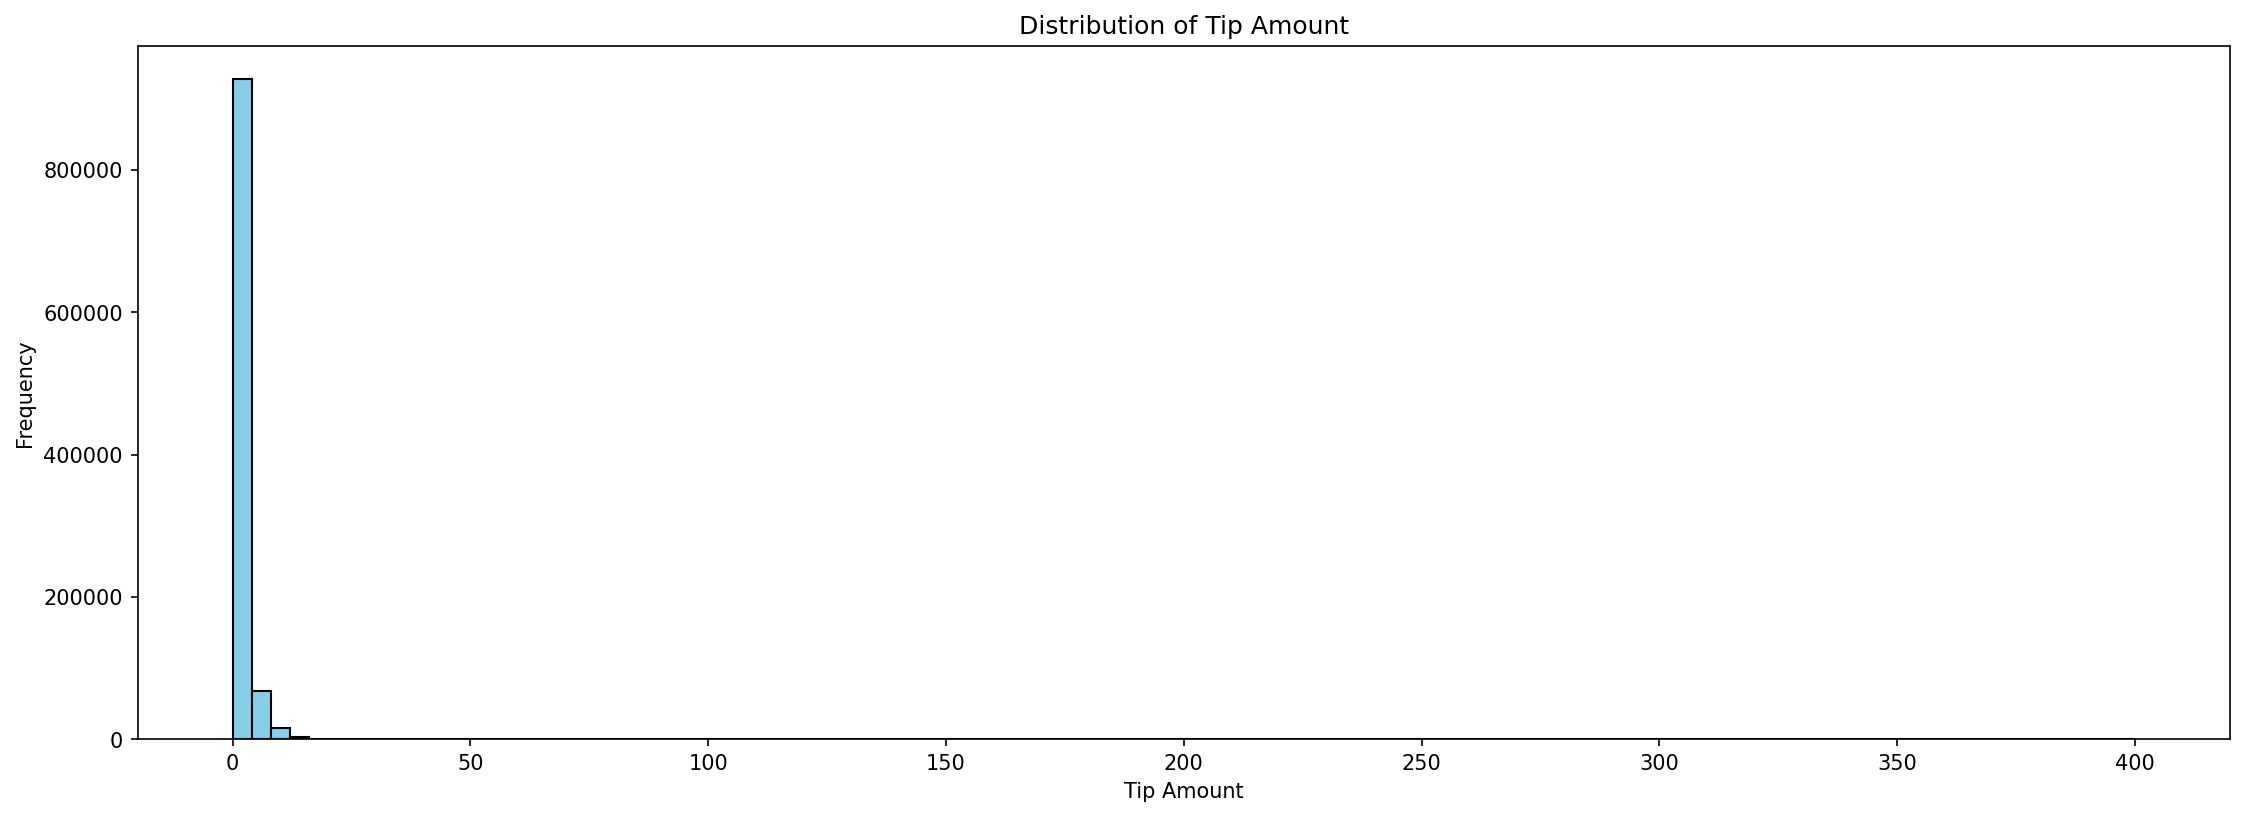

Mean of Tip Amount: 1.16
Median of Tip Amount: 0.00


In [10]:
plt.figure(figsize=(18, 6), dpi=150)

df['tip_amount'].plot(
    kind='hist',
    bins=100,
    color='skyblue',
    edgecolor='black',
    title="Distribution of Tip Amount"
)

plt.xlabel("Tip Amount")
plt.ylabel("Frequency")
plt.show()

print(f"Mean of Tip Amount: {df['tip_amount'].mean():.2f}")
print(f"Median of Tip Amount: {df['tip_amount'].median():.2f}")

<div id="sec_intro_to_intro" style="direction:ltl;line-height:200%;">
	<font face="XB Zar" size=4>
                The data is skewed and exhibits a long tail, making the median a more suitable choice for filling the null values in the tip amount.
        </font>
</div>

In [11]:
# Calculate the median of tip_amount
tip_mean = df['tip_amount'].median()

# Replace NaN values in tip_amount with its median
df['tip_amount'].fillna(tip_mean, inplace=True)

<div id="sec_intro_to_intro" style="direction:ltl;line-height:200%;">
	<font face="XB Zar" size=4>
                We will now plot the distribution of the total amount to determine whether the median or mean is more appropriate for replacing the null values.
        </font>
</div>

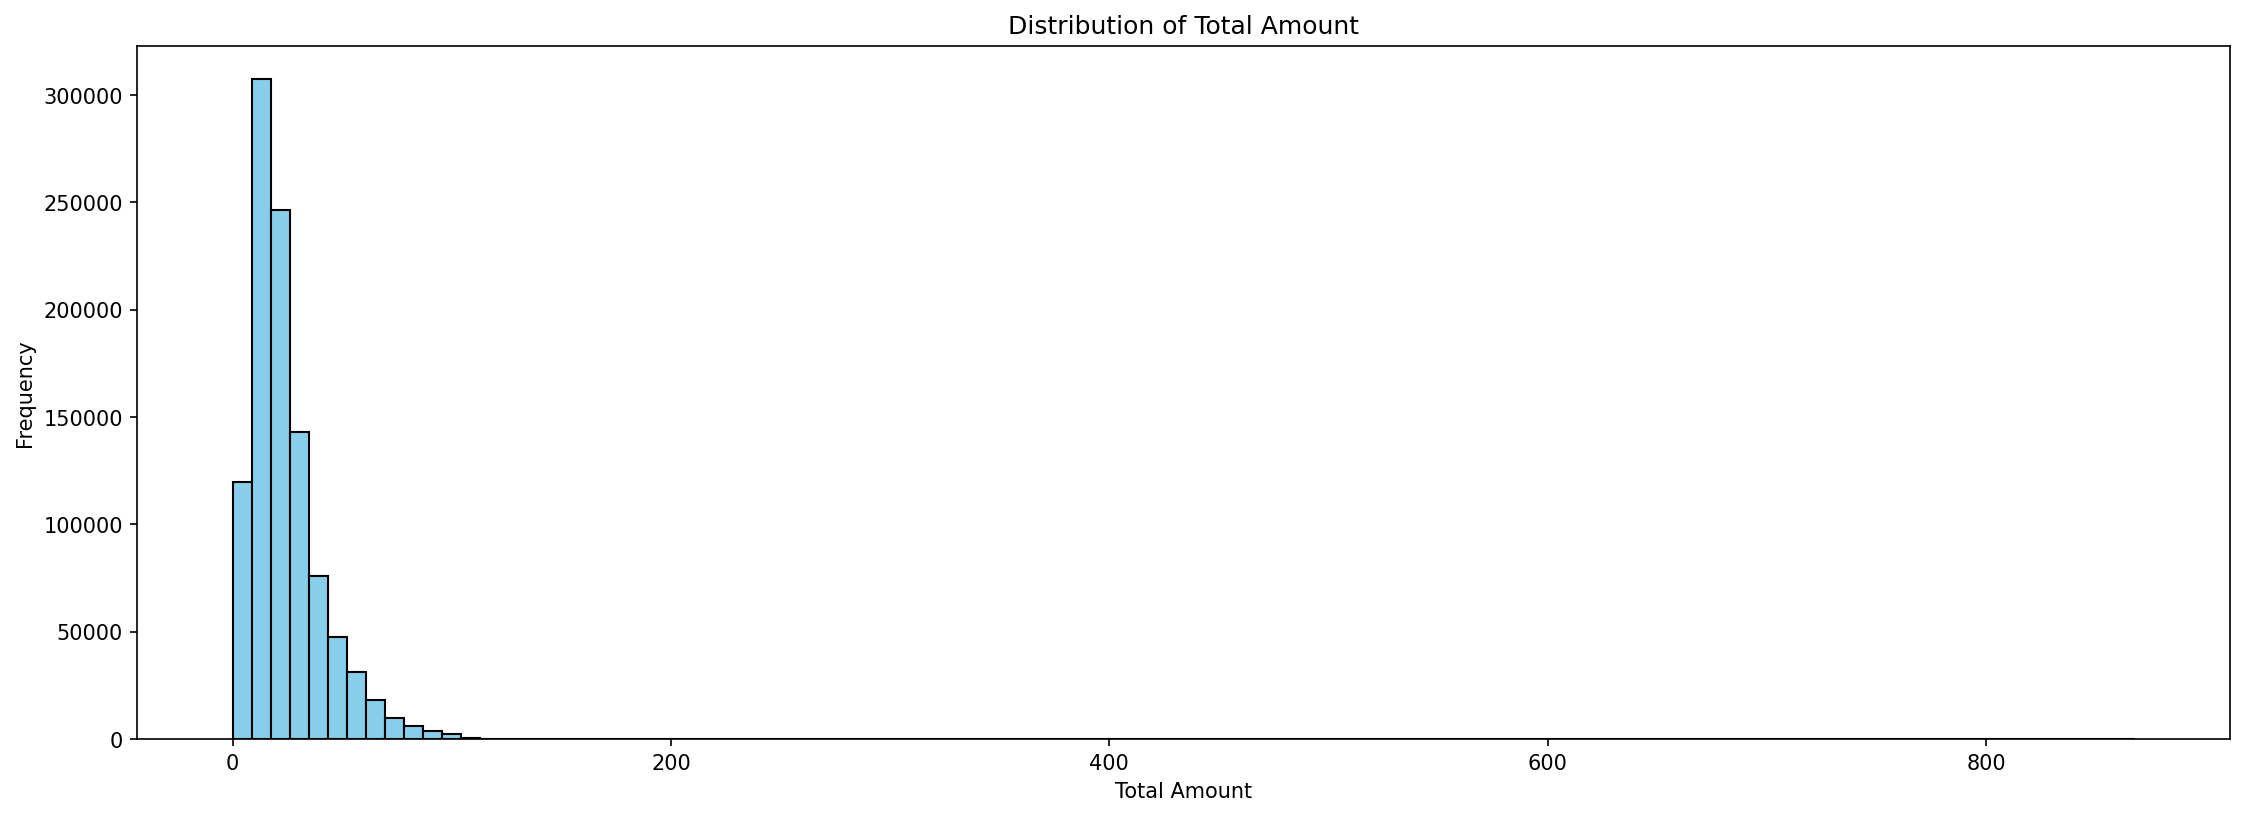

Mean of Total Amount: 24.07
Median of Total Amount: 19.88


In [12]:
plt.figure(figsize=(18, 6), dpi=150)
df['total_amount'].plot(
    kind='hist',
    bins=100,
    color='skyblue',
    edgecolor='black',
    title="Distribution of Total Amount"
)

plt.xlabel("Total Amount")
plt.ylabel("Frequency")

plt.show()

print(f"Mean of Total Amount: {df['total_amount'].mean():.2f}")
print(f"Median of Total Amount: {df['total_amount'].median():.2f}")

<div id="sec_intro_to_intro" style="direction:ltl;line-height:200%;">
	<font face="XB Zar" size=4>
                For the total amount, the data is also skewed with a very long tail. Large values can significantly distort the mean, making the median a more reliable choice for filling null values.
        </font>
</div>

In [13]:
# Calculate the mean of total_amount
total_amount_median = df['total_amount'].median()

# Replace NaN values in total_amount with its mean
df['total_amount'].fillna(total_amount_median, inplace=True)

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltl;line-height:300%;">
	<font face="XB Zar" size=4>
		<font color='crimson' size=6>
            Data Preprocessing
        </font>
		<p></p>
		<hr>
         In this section we will add Bouroughs to the data and define the necessary variables.</br>
        <br />
	</font>
</div>

In [14]:
df['speed'] = df['trip_distance'] / df['trip_time_in_minutes']

In [15]:
# Deriving hour, weekday, month and month day based on pickup_datetime
df['hour'] = df['lpep_pickup_datetime'].dt.hour

df['weekday'] = df['lpep_pickup_datetime'].dt.weekday

df['monthday'] = df['lpep_pickup_datetime'].dt.day

df['month'] = df['lpep_pickup_datetime'].dt.month

# Derive the date based on pickup_datetime
df['date'] = df['lpep_pickup_datetime'].dt.date

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,tolls_amount,total_amount,payment_type,trip_type,trip_time_in_minutes,trip_time_in_hours,speed,hour,weekday,monthday,month,date
0,2.0,2021-01-01 00:15:56,2021-01-01 00:19:52,43,151,1.0,1.01,0.00,0.0,6.80,2.0,1.0,3.933333,0.065556,0.256780,0,4,1,1,2021-01-01
1,2.0,2021-01-01 00:25:59,2021-01-01 00:34:44,166,239,1.0,2.53,2.81,0.0,16.86,1.0,1.0,8.750000,0.145833,0.289143,0,4,1,1,2021-01-01
2,2.0,2021-01-01 00:45:57,2021-01-01 00:51:55,41,42,1.0,1.12,1.00,0.0,8.30,1.0,1.0,5.966667,0.099444,0.187709,0,4,1,1,2021-01-01
7,2.0,2021-01-01 00:26:31,2021-01-01 00:28:50,75,75,6.0,0.45,0.96,0.0,5.76,5.0,2.0,2.316667,0.038611,0.194245,0,4,1,1,2021-01-01
9,2.0,2021-01-01 00:58:32,2021-01-01 01:32:34,225,265,1.0,12.19,2.75,0.0,42.05,1.0,1.0,34.033333,0.567222,0.358178,0,4,1,1,2021-01-01


In [16]:
# Add a new column to df to see if the date is a holiday or not
holidays = pd.read_csv(
    '/Applications/University/Semester-7/Transportation Planning/Project/Phase I/holidays.csv')

holidays['date'] = pd.to_datetime(holidays['date'], errors='coerce')
df['is_holiday'] = df['lpep_pickup_datetime'].dt.date.isin(
    holidays['date'].dt.date)

# Only keep working days, as stated in the project document
df = df[df['is_holiday'] == False]

df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,tolls_amount,total_amount,payment_type,trip_type,trip_time_in_minutes,trip_time_in_hours,speed,hour,weekday,monthday,month,date,is_holiday
94,2.0,2021-01-11 10:04:00,2021-01-11 10:10:00,244,244,NaN,0.81,1.06,0.0,8.36,1.0,NaN,6.000000,0.100000,0.135000,10,0,11,1,2021-01-11,False
612,2.0,2021-01-26 13:33:00,2021-01-26 13:42:00,49,225,NaN,1.64,0.00,0.0,19.78,NaN,NaN,9.000000,0.150000,0.182222,13,1,26,1,2021-01-26,False
634,2.0,2021-01-02 00:14:34,2021-01-02 00:19:53,42,244,1.0,1.25,0.00,0.0,7.30,1.0,1.0,5.316667,0.088611,0.235110,0,5,2,1,2021-01-02,False
635,2.0,2021-01-02 00:21:20,2021-01-02 00:52:01,75,220,1.0,9.11,0.00,0.0,32.30,1.0,1.0,30.683333,0.511389,0.296904,0,5,2,1,2021-01-02,False
636,1.0,2021-01-02 00:09:02,2021-01-02 00:15:59,65,232,1.0,3.70,0.00,0.0,16.05,2.0,1.0,6.950000,0.115833,0.532374,0,5,2,1,2021-01-02,False


In [17]:
# mapp the numerical values to their labels for weekday
weekday_mapping = {
    0: "Monday",
    1: "Tuesday",
    2: "Wednesday",
    3: "Thursday",
    4: "Friday",
    5: "Saturday",
    6: "Sunday"
}

df['weekday'] = df['weekday'].map(weekday_mapping)

In [18]:
# Only keep working days, as stated in the project document
df = df[~df['weekday'].isin(['Saturday', 'Sunday'])]

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            Classification of Day Hours:
        </font>
        <p></p>
        <hr />
        In this section, we aim to visualize a heatmap displaying the relationship between weekdays and hours of the day to classify the trips in different time categories. 
        <br />
    </font>
</div>


In [19]:
# Group data to calculate the number of trips for each hour and weekday
heatmap_data = df.groupby(['weekday', 'hour']).size().unstack()

# Reorder weekdays
ordered_days = ['Friday',
                'Thursday', 'Wednesday', 'Tuesday', 'Monday']
heatmap_data = heatmap_data.reindex(ordered_days)

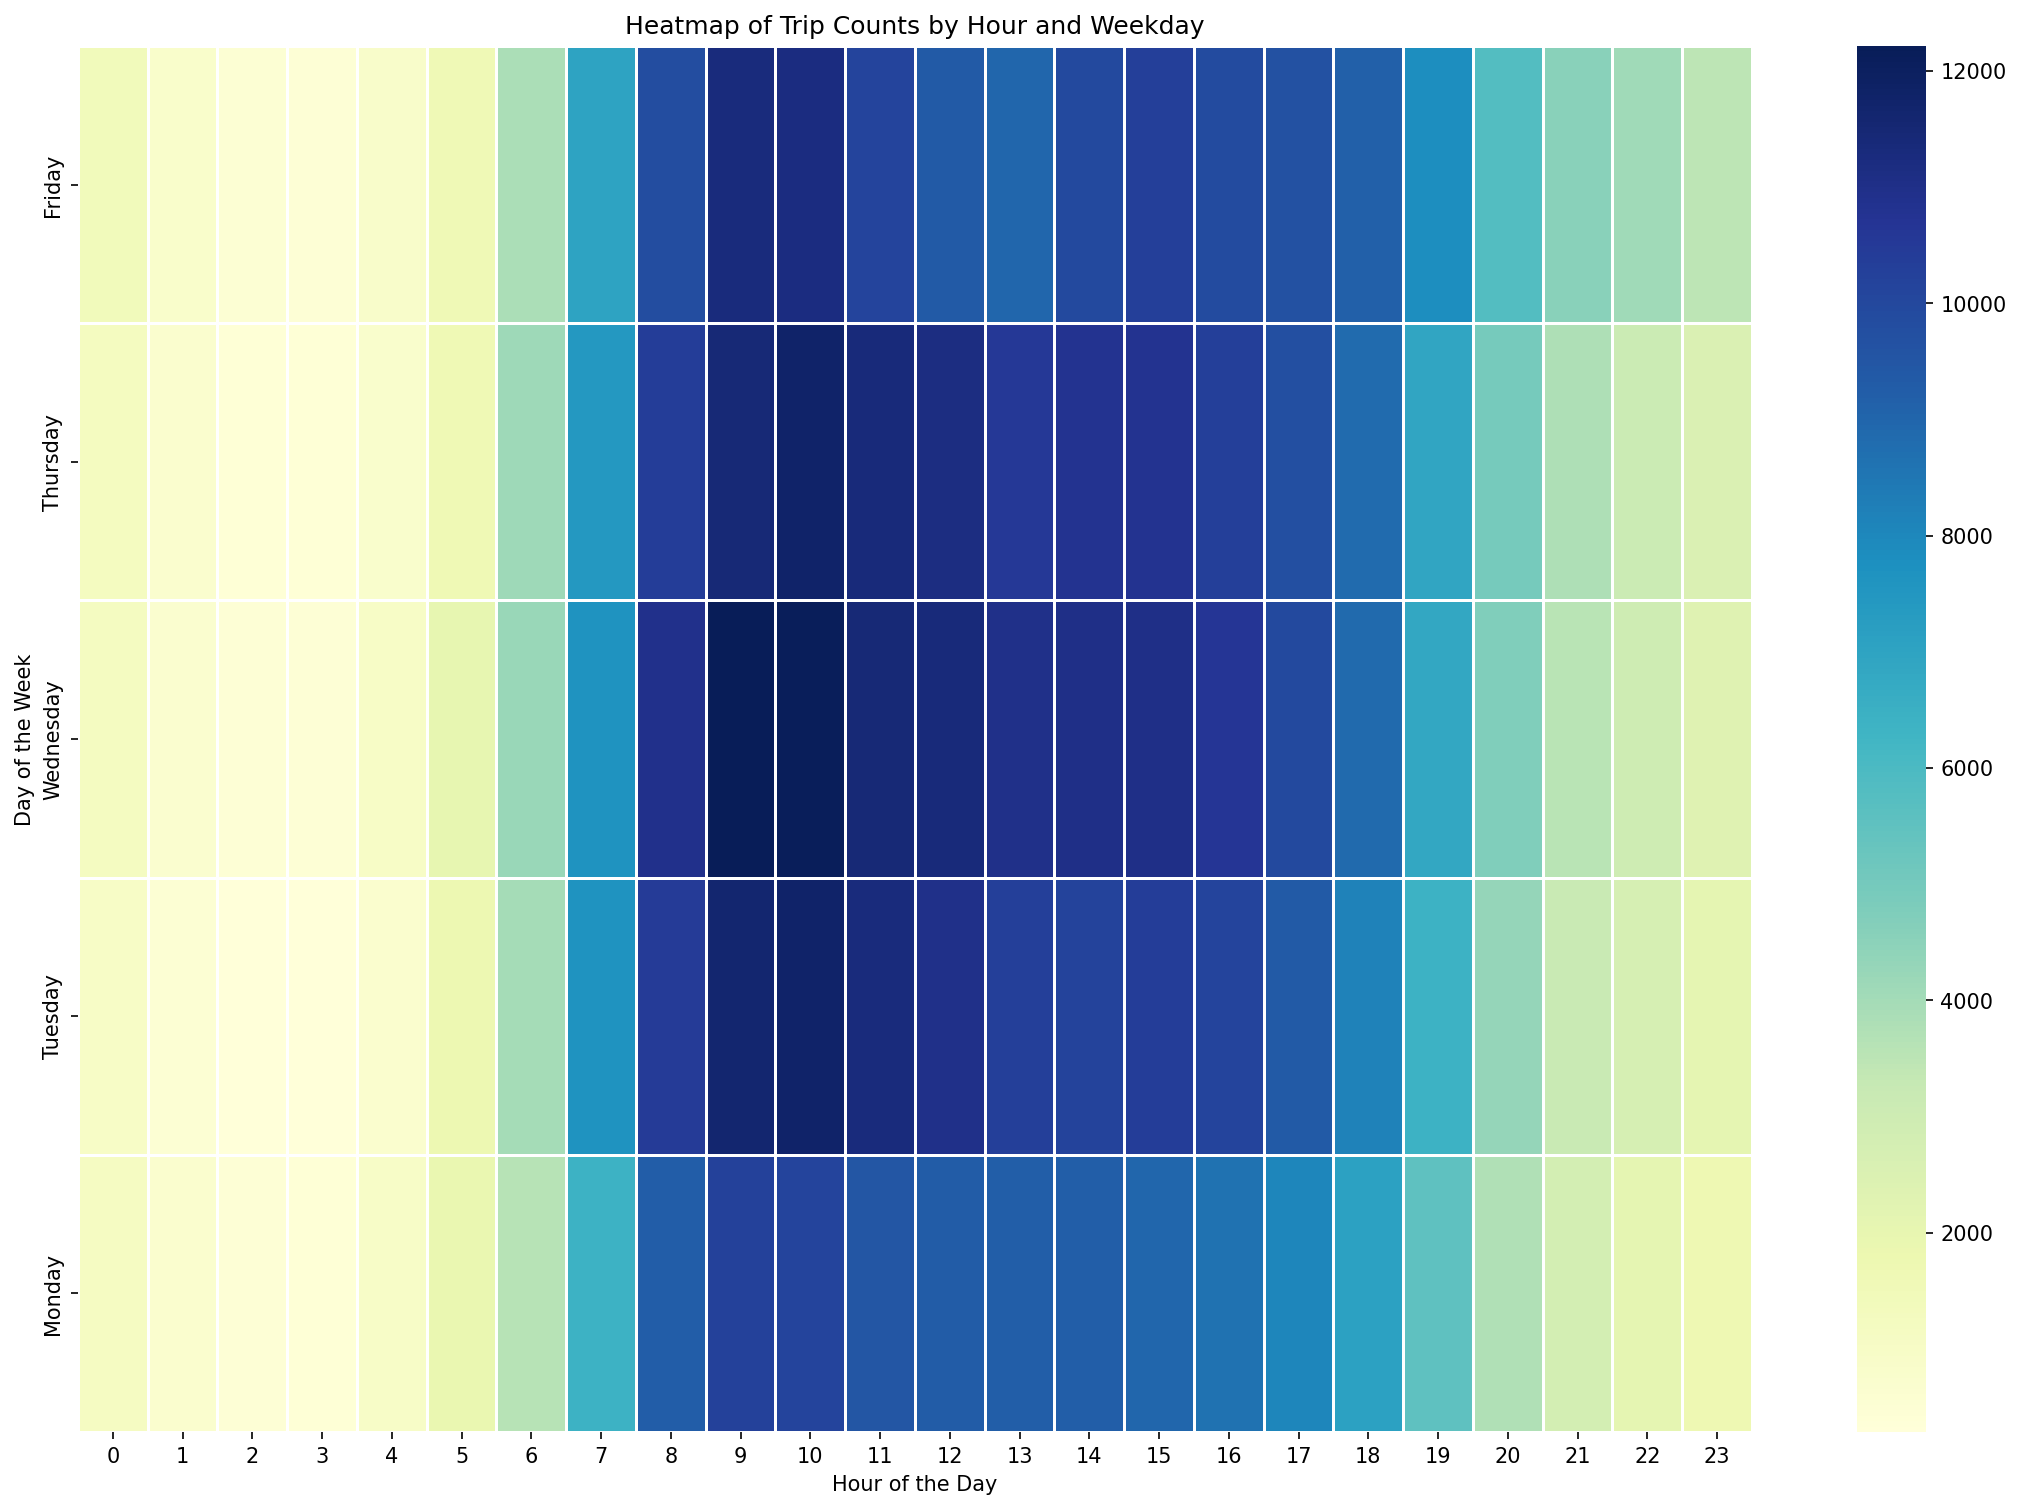

In [20]:
# Plot the heatmap
plt.figure(figsize=(18, 12), dpi=150)
sns.heatmap(heatmap_data, cmap="YlGnBu",
            annot=False, cbar=True, linewidths=0.5)
plt.title("Heatmap of Trip Counts by Hour and Weekday")
plt.xlabel("Hour of the Day")
plt.ylabel("Day of the Week")
plt.show()

<div id="sec_intro_to_intro" style="direction:ltr; line-height:200%;">
    <font face="XB Zar" size="4">
        <br />
        <p>Based on the heatmap, we can classify a day into three different categories:</p>
        <ul>
            <li> 0 AM to 6 AM (Midnight): The lowest amount of trips happen at this time interval.  </li>
            <li> 7 AM to 7 PM (Day): The peak of trips happen at this time interval because of work hours and daily activities. </li>
            <li> 8 PM to 11 PM (Night): The amount of trips at this time interval is mediocre. </li>
        </ul>
    </font>
</div>


In [21]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,tolls_amount,total_amount,payment_type,trip_type,trip_time_in_minutes,trip_time_in_hours,speed,hour,weekday,monthday,month,date,is_holiday
94,2.0,2021-01-11 10:04:00,2021-01-11 10:10:00,244,244,NaN,0.81,1.06,0.0,8.36,1.0,NaN,6.000000,0.100000,0.135000,10,Monday,11,1,2021-01-11,False
612,2.0,2021-01-26 13:33:00,2021-01-26 13:42:00,49,225,NaN,1.64,0.00,0.0,19.78,NaN,NaN,9.000000,0.150000,0.182222,13,Tuesday,26,1,2021-01-26,False
1271,2.0,2021-01-12 16:02:00,2021-01-12 16:28:00,188,178,NaN,3.82,0.00,0.0,20.04,NaN,NaN,26.000000,0.433333,0.146923,16,Tuesday,12,1,2021-01-12,False
1835,2.0,2021-01-12 16:04:00,2021-01-12 16:09:00,7,7,NaN,0.61,2.75,0.0,15.00,1.0,NaN,5.000000,0.083333,0.122000,16,Tuesday,12,1,2021-01-12,False
2639,2.0,2021-01-04 00:15:45,2021-01-04 00:23:34,41,74,4.0,1.36,0.00,0.0,8.80,2.0,1.0,7.816667,0.130278,0.173987,0,Monday,4,1,2021-01-04,False


In [22]:
# Define a function to classify based on the hour
def classify_trip(hour):
    if 0 <= hour <= 6:
        return 'Midnight'
    elif 7 <= hour <= 19:
        return 'Day'
    elif 20 <= hour <= 23:
        return 'Night'


# Apply the classification function to create a new 'time_of_day' column
df['time_group'] = df['hour'].apply(classify_trip)

<div id="sec_intro_to_intro" style="direction:ltl;line-height:200%;">
	<font face="XB Zar" size=4>
        <p>
        Now we will calculate the number of trips and the percentage of trips in each time group.
        </p>
        </font>
</div>

In [23]:
# Calculate the count of each time group
time_group_counts = df['time_group'].value_counts()

# Calculate the percentage of each time group
time_group_percentage = (time_group_counts / len(df)) * 100

# Display the percentages
print(time_group_counts)
print(time_group_percentage)

time_group
Day         631438
Night        68728
Midnight     46745
Name: count, dtype: int64
time_group
Day         84.539925
Night        9.201632
Midnight     6.258443
Name: count, dtype: float64


In [24]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,tolls_amount,total_amount,payment_type,trip_type,trip_time_in_minutes,trip_time_in_hours,speed,hour,weekday,monthday,month,date,is_holiday,time_group
94,2.0,2021-01-11 10:04:00,2021-01-11 10:10:00,244,244,NaN,0.81,1.06,0.0,8.36,1.0,NaN,6.000000,0.100000,0.135000,10,Monday,11,1,2021-01-11,False,Day
612,2.0,2021-01-26 13:33:00,2021-01-26 13:42:00,49,225,NaN,1.64,0.00,0.0,19.78,NaN,NaN,9.000000,0.150000,0.182222,13,Tuesday,26,1,2021-01-26,False,Day
1271,2.0,2021-01-12 16:02:00,2021-01-12 16:28:00,188,178,NaN,3.82,0.00,0.0,20.04,NaN,NaN,26.000000,0.433333,0.146923,16,Tuesday,12,1,2021-01-12,False,Day
1835,2.0,2021-01-12 16:04:00,2021-01-12 16:09:00,7,7,NaN,0.61,2.75,0.0,15.00,1.0,NaN,5.000000,0.083333,0.122000,16,Tuesday,12,1,2021-01-12,False,Day
2639,2.0,2021-01-04 00:15:45,2021-01-04 00:23:34,41,74,4.0,1.36,0.00,0.0,8.80,2.0,1.0,7.816667,0.130278,0.173987,0,Monday,4,1,2021-01-04,False,Midnight


<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltl;line-height:300%;">
	<font face="XB Zar" size=4>
		<font color='crimson' size=7>
            Section 1
        </font>
	</font>
</div>

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            OD Matrix
        </font>
        <p></p>
        <hr />
        We will now import the file containing LocationIDs and their corresponding regions to assign the origin and destination regions to each trip. This information will be used for constructing the OD Matrix.
    </font>
</div>


In [25]:
# Read the file that assigns LocationID to different regions
locations_file = '/Applications/University/Semester-7/Transportation Planning/Project/Phase I/Boroughs.csv'
locations_df = pd.read_csv(locations_file)

In [26]:
# Merge trips data with location data (for both pickup and dropoff locations)
# The name of the new column will be the same as the one in the original file
df_merged = df.merge(locations_df, left_on='PULocationID',
                     right_on='LocationID', how='left', suffixes=('', '_pickup'))

# Suffixes will be applied when already there is a column with that name
df_merged = df_merged.merge(locations_df, left_on='DOLocationID',
                            right_on='LocationID', how='left', suffixes=('', '_dropoff'))

df_merged.drop(columns=['LocationID', 'LocationID_dropoff'], inplace=True)
df_merged.rename(columns={'Borough': 'pickup_region',
                 'Borough_dropoff': 'dropoff_region'}, inplace=True)

In [27]:
df_merged.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,tolls_amount,total_amount,payment_type,trip_type,trip_time_in_minutes,trip_time_in_hours,speed,hour,weekday,monthday,month,date,is_holiday,time_group,pickup_region,dropoff_region
0,2.0,2021-01-11 10:04:00,2021-01-11 10:10:00,244,244,NaN,0.81,1.06,0.0,8.36,1.0,NaN,6.000000,0.100000,0.135000,10,Monday,11,1,2021-01-11,False,Day,Manhattan,Manhattan
1,2.0,2021-01-26 13:33:00,2021-01-26 13:42:00,49,225,NaN,1.64,0.00,0.0,19.78,NaN,NaN,9.000000,0.150000,0.182222,13,Tuesday,26,1,2021-01-26,False,Day,Brooklyn,Brooklyn
2,2.0,2021-01-12 16:02:00,2021-01-12 16:28:00,188,178,NaN,3.82,0.00,0.0,20.04,NaN,NaN,26.000000,0.433333,0.146923,16,Tuesday,12,1,2021-01-12,False,Day,Brooklyn,Brooklyn
3,2.0,2021-01-12 16:04:00,2021-01-12 16:09:00,7,7,NaN,0.61,2.75,0.0,15.00,1.0,NaN,5.000000,0.083333,0.122000,16,Tuesday,12,1,2021-01-12,False,Day,Queens,Queens
4,2.0,2021-01-04 00:15:45,2021-01-04 00:23:34,41,74,4.0,1.36,0.00,0.0,8.80,2.0,1.0,7.816667,0.130278,0.173987,0,Monday,4,1,2021-01-04,False,Midnight,Manhattan,Manhattan


In [28]:
df_merged.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,PULocationID,DOLocationID,passenger_count,trip_distance,tip_amount,tolls_amount,total_amount,payment_type,trip_type,trip_time_in_minutes,trip_time_in_hours,speed,hour,weekday,monthday,month,date,is_holiday,time_group,pickup_region,dropoff_region
0,2.0,2021-01-11 10:04:00,2021-01-11 10:10:00,244,244,NaN,0.81,1.06,0.0,8.36,1.0,NaN,6.000000,0.100000,0.135000,10,Monday,11,1,2021-01-11,False,Day,Manhattan,Manhattan
1,2.0,2021-01-26 13:33:00,2021-01-26 13:42:00,49,225,NaN,1.64,0.00,0.0,19.78,NaN,NaN,9.000000,0.150000,0.182222,13,Tuesday,26,1,2021-01-26,False,Day,Brooklyn,Brooklyn
2,2.0,2021-01-12 16:02:00,2021-01-12 16:28:00,188,178,NaN,3.82,0.00,0.0,20.04,NaN,NaN,26.000000,0.433333,0.146923,16,Tuesday,12,1,2021-01-12,False,Day,Brooklyn,Brooklyn
3,2.0,2021-01-12 16:04:00,2021-01-12 16:09:00,7,7,NaN,0.61,2.75,0.0,15.00,1.0,NaN,5.000000,0.083333,0.122000,16,Tuesday,12,1,2021-01-12,False,Day,Queens,Queens
4,2.0,2021-01-04 00:15:45,2021-01-04 00:23:34,41,74,4.0,1.36,0.00,0.0,8.80,2.0,1.0,7.816667,0.130278,0.173987,0,Monday,4,1,2021-01-04,False,Midnight,Manhattan,Manhattan


<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            Q1: Calculating OD Matrix for Boroughs
        </font>
    </font>
</div>

In [29]:
# Group by origin (pickup_region) and destination (dropoff_region), counting trips
od_matrix_data = df_merged.groupby(
    ['dropoff_region', 'pickup_region']).size().reset_index(name='num_trips')

# Pivot the data to create an OD matrix
od_matrix = od_matrix_data.pivot(
    index='pickup_region', columns='dropoff_region', values='num_trips')

# Replace possible null values with zero, as no trip has been done with that trip_type
od_matrix.fillna(0, inplace=True)

od_matrix.head(10)

dropoff_region,Bronx,Brooklyn,EWR,Manhattan,Queens,Staten Island
pickup_region,,,,,,
Bronx,60534.0,4548.0,6.0,21651.0,4784.0,255.0
Brooklyn,4435.0,132665.0,194.0,22751.0,14397.0,968.0
EWR,0.0,0.0,1.0,2.0,0.0,0.0
Manhattan,28519.0,9658.0,135.0,273898.0,11408.0,249.0
Queens,4910.0,13844.0,15.0,16419.0,118853.0,234.0
Staten Island,232.0,663.0,5.0,223.0,236.0,219.0


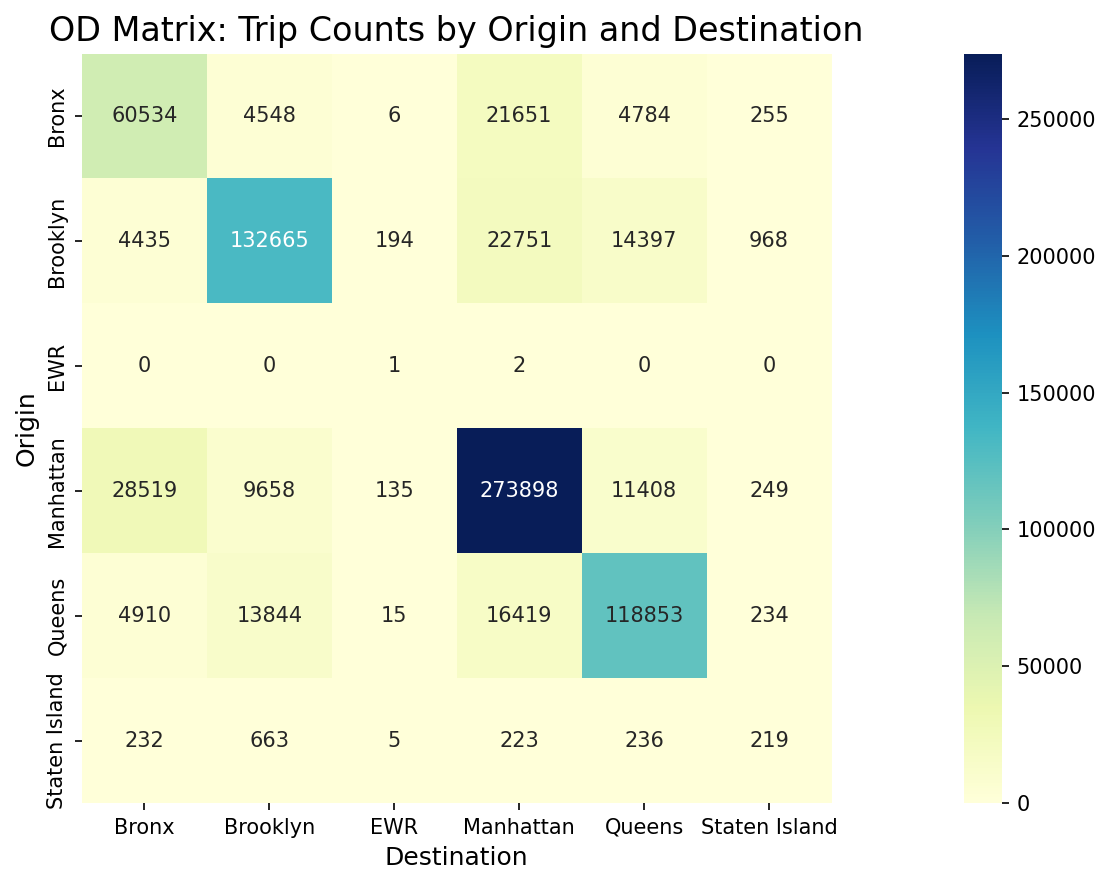

In [30]:
# Plot the heatmap for OD Matrix
plt.figure(figsize=(18, 6), dpi=150)
sns.heatmap(od_matrix, cmap="YlGnBu", square=True,
            cbar=True, annot=True, fmt=".0f")
plt.title("OD Matrix: Trip Counts by Origin and Destination", fontsize=16)
plt.xlabel("Destination", fontsize=12)
plt.ylabel("Origin", fontsize=12)
plt.tight_layout()
plt.show()

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            Q2
        </font>
    </font>
</div>

In [31]:
# Replace diagonal values with zero, in order to sort
od_matrix2 = od_matrix.copy()
for i in od_matrix2.index:
    od_matrix2.loc[i, i] = 0

In [32]:
# Convert the DataFrame to a Series for easier sorting
od_series = od_matrix2.stack()

# Sort regions in a descending order
od_series = od_series.sort_values(ascending=False)

od_series

pickup_region  dropoff_region
Manhattan      Bronx             28519.0
Brooklyn       Manhattan         22751.0
Bronx          Manhattan         21651.0
Queens         Manhattan         16419.0
Brooklyn       Queens            14397.0
Queens         Brooklyn          13844.0
Manhattan      Queens            11408.0
               Brooklyn           9658.0
Queens         Bronx              4910.0
Bronx          Queens             4784.0
               Brooklyn           4548.0
Brooklyn       Bronx              4435.0
               Staten Island       968.0
Staten Island  Brooklyn            663.0
Bronx          Staten Island       255.0
Manhattan      Staten Island       249.0
Staten Island  Queens              236.0
Queens         Staten Island       234.0
Staten Island  Bronx               232.0
               Manhattan           223.0
Brooklyn       EWR                 194.0
Manhattan      EWR                 135.0
Queens         EWR                  15.0
Bronx          EWR         

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltl;line-height:300%;">
	<font face="XB Zar" size=4>
		<font color='crimson' size=7>
            Section 2
        </font>
	</font>
</div>

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            Calculating OD Matrix for Zones
        </font>
    </font>
</div>


In [33]:
# Group by origin (pickup_region) and destination (dropoff_region), counting trips
od_matrix_data = df_merged.groupby(
    ['DOLocationID', 'PULocationID']).size().reset_index(name='num_trips')

# Pivot the data to create an OD matrix
od_matrix = od_matrix_data.pivot(
    index='PULocationID', columns='DOLocationID', values='num_trips')

# Replace possible null values with zero
od_matrix.fillna(0, inplace=True)

# Ensure all zones (1 to 265) are included in the matrix
all_zones = range(1, 266)

# If a zone does not exist in the origins or destinations, add a row or a column that consists zeros.
od_matrix = od_matrix.reindex(index=all_zones, columns=all_zones, fill_value=0)

# Add a new row with the sum of each column
od_matrix['Total O'] = od_matrix.sum(axis=1)

# Add a new column with the sum of each row
od_matrix.loc['Total D'] = od_matrix.sum(axis=0)

display(od_matrix)

DOLocationID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,Total O
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0
3,0.0,0.0,79.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,10.0,1.0,9.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,27.0,0.0,0.0,0.0,1.0,1.0,2.0,3.0,0.0,5.0,33.0,1.0,0.0,0.0,9.0,13.0,6.0,0.0,9.0,102.0,0.0,0.0,0.0,5.0,1.0,0.0,3.0,0.0,6.0,2.0,0.0,2.0,0.0,2.0,0.0,0.0,3.0,29.0,1.0,3.0,0.0,0.0,25.0,32.0,3.0,2.0,25.0,8.0,2.0,46.0,1.0,0.0,0.0,1.0,3.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,17.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,24.0,0.0,0.0,4.0,1.0,0.0,0.0,1.0,0.0,0.0,6.0,0.0,0.0,0.0,2.0,0.0,2.0,0.0,0.0,0.0,17.0,5.0,1.0,0.0,8.0,4.0,14.0,4.0,1.0,0.0,2.0,11.0,0.0,0.0,1

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            Sub-OD Matrix
        </font>
        <p></p>
        <hr />
        Now we want to derive the 25 zones that has the most sum of Total O and Total D, and construct the OD Matrix based on these 25 zones.
    </font>
</div>


In [34]:
# Deriving the last column (Total Dropoff for each Pickup Location)
totalO = od_matrix.iloc[:, -1].tolist()

# Deriving the last row (Total Pickup for each Dropoff Location)
totalD = od_matrix.iloc[-1, :].tolist()

# Remove the last element of each list.
totalO = totalO[:-1]
totalD = totalD[:-1]

# Calculate the total number of trips for each zone.
sum_trips = [a + b for a, b in zip(totalO, totalD)]

In [35]:
# Get the indices of the top 25 maximum values
top_25_indices = np.argsort(sum_trips)[-25:][::-1]

# Convert the indices to LocationID or zone number
top_25_indices = top_25_indices + 1

# Display the 25 zones that have maximum number of trips
print("Indices of the 25 maximum numbers in the original list:", top_25_indices)

Indices of the 25 maximum numbers in the original list: [ 74  75  41  42 166 244  95  97  43   7  82 236  61 116  65 130 129 238
 181  33 188 242  76 263 197]


In [36]:
# Filter the original data for the top 25 zones
df_filtered = df_merged[df_merged['PULocationID'].isin(
    top_25_indices) & df_merged['DOLocationID'].isin(top_25_indices)]

In [37]:
# Group by origin (pickup_region) and destination (dropoff_region), counting trips
od_matrix_data = df_filtered.groupby(
    ['DOLocationID', 'PULocationID']).size().reset_index(name='num_trips')

# Pivot the data to create an OD matrix
od_matrix = od_matrix_data.pivot(
    index='PULocationID', columns='DOLocationID', values='num_trips')

# Replace possible null values with zero
od_matrix.fillna(0, inplace=True)


# Add a new row with the sum of each column
od_matrix['Total O'] = od_matrix.sum(axis=1)

# Add a new column with the sum of each row
od_matrix.loc['Total D'] = od_matrix.sum(axis=0)

display(od_matrix)

DOLocationID,7,33,41,42,43,61,65,74,75,76,82,95,97,116,129,130,166,181,188,197,236,238,242,244,263,Total O
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,,
7,2879.0,24.0,19.0,13.0,36.0,24.0,13.0,37.0,70.0,21.0,281.0,102.0,15.0,25.0,587.0,57.0,17.0,9.0,3.0,36.0,69.0,29.0,9.0,20.0,61.0,4456.0
33,7.0,529.0,9.0,10.0,14.0,345.0,182.0,13.0,29.0,134.0,4.0,35.0,337.0,9.0,7.0,6.0,4.0,390.0,175.0,6.0,74.0,19.0,0.0,3.0,35.0,2376.0
41,33.0,12.0,3784.0,5068.0,811.0,39.0,25.0,4178.0,2718.0,16.0,7.0,24.0,9.0,1309.0,14.0,6.0,2261.0,9.0,34.0,27.0,1180.0,1380.0,50.0,749.0,629.0,24372.0
42,20.0,33.0,2974.0,3565.0,409.0,20.0,15.0,2223.0,1616.0,39.0,4.0,17.0,14.0,1060.0,7.0,34.0,1035.0,6.0,18.0,6.0,526.0,478.0,126.0,1067.0,358.0,15670.0
43,21.0,13.0,199.0,148.0,633.0,9.0,4.0,319.0,546.0,7.0,6.0,13.0,1.0,45.0,18.0,6.0,195.0,11.0,9.0,6.0,1576.0,1268.0,2.0,80.0,800.0,5935.0
61,5.0,199.0,37.0,19.0,9.0,1095.0,171.0,28.0,30.0,287.0,9.0,14.0,374.0,11.0,4.0,22.0,3.0,315.0,518.0,20.0,7.0,6.0,13.0,19.0,8.0,3223.0
65,11.0,298.0,9.0,13.0,9.0,1013.0,235.0,9.0,20.0,136.0,7.0,16.0,1199.0,6.0,10.0,7.0,5.0,820.0,426.0,12.0,24.0,10.0,6.0,7.0,19.0,4327.0
74,92.0,19.0,5239.0,4807.0,2869.0,24.0,16.0,5265.0,11991.0,14.0,44.0,15.0,44.0,1503.0,23.0,26.0,4249.0,14.0,14.0,101.0,5218.0,2938.0,66.0,1559.0,3177.0,49327.0
75,175.0,54.0,3786.0,3397.0,982.0,48.0,27.0,12567.0,5729.0,61.0,65.0,112.0,50.0,743.0,126.0,49.0,1766.0,55.0,26.0,47.0,4322.0,3363.0,107.0,701.0,3411.0,41769.0


In [38]:
od_matrix_columns = od_matrix.columns
df["tip_paid"] = df["tip_amount"] > 0
df.head()
mean_result_df = df.groupby(['PULocationID', "DOLocationID", "time_group"])[
    'tip_paid'].mean().reset_index()
mean_result_df.head()

filtered_df = mean_result_df[
    (mean_result_df['PULocationID'].isin(od_matrix_columns)) &
    (mean_result_df['DOLocationID'].isin(od_matrix_columns))
]

filtered_df.reset_index(drop=True, inplace=True)
filtered_df.head()

time_groups = ['Day', 'Midnight', 'Night']

# Get the unique pairs of PULocationID and DOLocationID
puls_duls = filtered_df[['PULocationID', 'DOLocationID']].drop_duplicates()

# Create a full set of all combinations of PULocationID, DOLocationID, and time_group
full_combinations = pd.MultiIndex.from_product(
    [puls_duls['PULocationID'].unique(), puls_duls['DOLocationID'].unique(),
     time_groups],
    names=['PULocationID', 'DOLocationID', 'time_group']
)

# Reindex the DataFrame to include all these combinations
df_full = filtered_df.set_index(['PULocationID', 'DOLocationID', 'time_group']).reindex(
    full_combinations, fill_value=0).reset_index()

# The 'tip_paid' will be 0 for any combination that didn't exist in the original data
df_full['tip_paid'] = df_full['tip_paid'].apply(lambda x: x if x != 0 else 0)

# Display the resulting DataFrame
df_full.to_csv('tip_paid.csv', index=False)

In [39]:
# Deriving the last column (Total Dropoff for each Pickup Location)
totalO = od_matrix.iloc[:, -1].tolist()

# Deriving the last row (Total Pickup for each Dropoff Location)
totalD = od_matrix.iloc[-1, :].tolist()

totalO = totalO[:-1]
totalD = totalD[:-1]

# Check if the OD Matrix is balanced
sum_O = sum(totalO)
sum_D = sum(totalD)
print(sum_O, sum_D)

213761.0 213761.0


<div id="sec_intro_to_intro" style="direction:ltl;line-height:200%;">
	<font face="XB Zar" size=4>
        <p>
        As we can see the OD Matrix is balanced and we don't have to do anything.
        </p>
        <p>
        Now we will calculate the number of trips and the percentage of trips in each time group.
        </p>
        </font>
</div>

In [40]:
# Calculate the count of each time group
time_group_counts = df_filtered['time_group'].value_counts()

# Calculate the percentage of each time group
time_group_percentage = (time_group_counts / sum(time_group_counts)) * 100

# Display the percentages
print(time_group_counts)
print(time_group_percentage)
time_group_percentage = (time_group_percentage/100).to_dict()
pd.DataFrame(time_group_percentage, index=[0]).to_csv(
    'time_group_percentage.csv', index=False)

time_group
Day         182065
Night        21741
Midnight      9955
Name: count, dtype: int64
time_group
Day         85.172225
Night       10.170705
Midnight     4.657070
Name: count, dtype: float64


<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            Price Matrix
        </font>
    </font>
</div>


In [41]:
# Group by pickup and dropoff zones from the filtered data and calculate the average of 'total_amount'
avg_price = df_filtered.groupby(['PULocationID', 'DOLocationID'])[
    'total_amount'].mean().reset_index(name='avg_price')

# Pivot the data to create a matrix for average prices
price_matrix = avg_price.pivot(
    index='PULocationID', columns='DOLocationID', values='avg_price')

# Replace possible null values with zero (if no trips between certain zones)
# price_matrix.fillna(0, inplace=True)

# Display the resulting average price matrix
display(price_matrix)

DOLocationID,7,33,41,42,43,61,65,74,75,76,82,95,97,116,129,130,166,181,188,197,236,238,242,244,263
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,
7,10.474554,39.085417,34.494737,30.884615,27.511389,40.211250,36.760769,28.359459,29.026286,43.310952,19.729929,29.631275,36.958667,34.291600,14.894020,38.860702,34.967647,44.855556,42.023333,36.584167,27.191884,34.233448,44.698889,40.805500,26.440984
33,33.634286,10.363629,45.884444,50.027000,42.753571,22.477536,9.686978,47.468462,42.392069,36.606791,34.820000,47.308571,13.369496,53.567778,35.157143,71.966667,44.730000,15.468949,23.957600,67.300000,41.758649,39.636842,NaN,56.753333,38.786000
41,31.129697,47.289167,8.140177,9.215351,13.225277,56.596410,45.169600,9.304631,10.644581,55.860625,34.628571,54.750833,47.435556,12.345623,39.096429,54.948333,9.069743,56.253333,56.586471,47.128889,16.808085,14.084674,38.315400,16.746956,18.159762
42,31.477500,44.762121,9.483208,8.903332,15.925452,52.907000,46.638000,11.703162,15.772351,59.701795,38.710000,44.654706,50.368571,9.979755,33.018571,53.738235,11.421932,57.125000,56.035556,54.125000,21.073213,18.243222,34.518492,15.660797,22.679469
43,29.491429,41.290000,11.007839,16.163243,12.574028,53.473333,37.302500,10.922539,8.917399,52.250000,40.620000,44.001538,33.300000,20.362889,40.931111,52.790000,13.132615,54.846364,45.456667,53.128333,12.030082,11.299464,36.545000,22.221625,13.091325
61,41.868000,23.906935,54.063514,54.815263,42.470000,18.035680,23.561579,54.509643,41.894333,26.524216,38.813333,36.350000,20.492005,56.453636,48.867500,45.896818,53.446667,21.553619,21.316757,34.997500,43.814286,45.251667,62.071538,57.811579,49.322500
65,35.836364,12.477181,44.166667,46.083846,48.873333,19.172478,12.358723,43.136667,38.658500,33.915147,37.015714,38.166875,10.562277,54.478333,33.284000,57.042857,42.638000,13.730329,20.198967,60.825000,41.149167,43.351000,63.771667,52.038571,41.136316
74,26.853152,42.656842,9.032113,10.725417,12.255674,49.384583,43.826250,8.893031,10.361549,57.264286,35.289773,42.432667,47.893864,14.449082,29.077826,55.388077,11.863733,49.889286,54.392143,51.464356,16.639885,18.219272,35.759848,18.709846,16.196317
75,29.947143,40.210000,9.913384,13.882664,12.330794,46.620833,38.500000,9.247719,8.520606,54.200984,36.278154,45.779375,40.217000,17.806635,36.078889,59.270000,12.880147,49.252182,51.193462,50.978723,12.043406,12.396509,33.989533,23.110842,12.728786


<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            Price Matrix classified based on time groups
        </font>
        <p></p>
        <hr />
        Now we want to construct price matrices based on time groups. 
    </font>
</div>


In [42]:
# Construct the Price Matrix for Midnight:

# Filter the data and keep the relavant time group
df_midnight = df_filtered[df_filtered['time_group'] == 'Midnight']

# Group by pickup and dropoff zones from the filtered data and calculate the average of 'total_amount'
avg_price = df_midnight.groupby(['PULocationID', 'DOLocationID'])[
    'total_amount'].mean().reset_index(name='avg_price')

# Pivot the data to create a matrix for average prices
midnight_price_matrix = avg_price.pivot(
    index='PULocationID', columns='DOLocationID', values='avg_price')

# Replace possible null values with zero (if no trips between certain zones)
# price_matrix.fillna(0, inplace=True)

# Display the resulting average price matrix
display(midnight_price_matrix)

DOLocationID,7,33,41,42,43,61,65,74,75,76,82,95,97,116,129,130,166,181,188,197,236,238,242,244,263
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,
7,11.046981,31.800000,48.850000,30.430000,21.805000,52.880000,NaN,23.950000,26.913333,48.201667,15.063810,31.048000,35.060000,28.183333,15.755455,38.493750,31.523333,NaN,NaN,35.102000,22.080000,NaN,NaN,37.290000,25.727500
33,NaN,15.750000,NaN,NaN,NaN,14.780000,9.220000,NaN,NaN,NaN,NaN,NaN,11.286000,NaN,NaN,NaN,NaN,12.830000,16.576667,NaN,NaN,38.050000,NaN,NaN,38.340000
41,27.134000,42.580000,7.087333,8.659861,9.994615,49.050000,42.027000,10.065043,9.653600,NaN,NaN,47.220000,NaN,11.118070,59.350000,47.950000,7.404746,NaN,60.900000,44.770000,13.478500,12.330698,43.286000,15.764130,18.049000
42,23.635000,NaN,9.229098,7.901824,10.725000,NaN,46.820000,12.366552,14.040000,NaN,NaN,44.303333,NaN,8.648615,NaN,56.150000,10.775676,NaN,52.050000,NaN,20.976364,17.995417,33.178947,16.629259,25.625957
43,25.350000,NaN,9.330000,16.383333,7.630000,NaN,NaN,10.800000,7.890000,NaN,NaN,NaN,NaN,20.640000,NaN,NaN,11.547143,NaN,NaN,NaN,10.444737,9.682500,NaN,22.730000,10.000000
61,NaN,21.300000,NaN,48.870000,NaN,20.730000,23.980000,47.390000,39.760000,26.716667,36.140000,NaN,17.410000,50.120000,NaN,NaN,43.040000,23.043750,22.603947,NaN,NaN,43.040000,60.930000,NaN,NaN
65,NaN,8.160000,35.800000,50.000000,NaN,17.272500,58.930000,NaN,NaN,25.435000,27.800000,NaN,11.725714,NaN,NaN,NaN,NaN,13.455000,13.930000,62.700000,NaN,NaN,NaN,NaN,NaN
74,23.677500,38.285000,8.282391,11.370662,9.525673,47.510000,39.760000,9.795100,9.315227,NaN,34.277778,NaN,34.050000,12.157536,29.385000,53.000000,9.343381,NaN,NaN,50.983684,13.605372,15.941379,37.128462,16.881200,17.043973
75,24.755000,38.140000,8.157266,11.968919,11.070000,NaN,38.750000,7.834144,8.406815,NaN,34.323333,31.483333,NaN,14.677000,NaN,NaN,11.639184,44.190000,56.663333,53.966667,11.119159,10.952315,32.050000,21.528462,13.001095


In [43]:
# Construct the Price Matrix for Day:

# Filter the data and keep the relavant time group
df_day = df_filtered[df_filtered['time_group'] == 'Day']

# Group by pickup and dropoff zones from the filtered data and calculate the average of 'total_amount'
avg_price = df_day.groupby(['PULocationID', 'DOLocationID'])[
    'total_amount'].mean().reset_index(name='avg_price')

# Pivot the data to create a matrix for average prices
day_price_matrix = avg_price.pivot(
    index='PULocationID', columns='DOLocationID', values='avg_price')

# Replace possible null values with zero (if no trips between certain zones)
# price_matrix.fillna(0, inplace=True)

# Display the resulting average price matrix
display(day_price_matrix)

DOLocationID,7,33,41,42,43,61,65,74,75,76,82,95,97,116,129,130,166,181,188,197,236,238,242,244,263
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,
7,10.598080,38.340476,33.173333,30.992000,28.701333,40.338889,35.626364,29.080000,29.490690,41.661429,20.804463,29.676316,38.543000,38.586923,15.116674,38.975319,36.640000,46.233333,42.023333,37.628400,27.507193,34.878696,44.698889,41.801250,26.702826
33,33.480000,10.399264,44.372857,51.357778,42.753571,22.649310,10.030748,48.398182,42.672143,36.670227,34.820000,47.308571,13.697908,54.984286,34.571667,71.966667,44.730000,15.715592,24.352919,67.300000,41.900308,39.375882,NaN,56.753333,39.033939
41,32.813000,48.922857,8.229114,9.300834,13.285228,56.487857,47.264667,9.341831,10.741276,57.312308,34.628571,55.906818,44.588000,12.607455,38.225556,56.348000,9.102878,58.505000,55.765172,46.905455,16.943342,14.201415,37.574706,16.980957,18.472803
42,34.225000,44.762121,9.478271,9.067255,16.188647,51.832941,45.666364,11.859675,16.118067,59.701795,40.163333,44.331000,49.405000,10.238058,33.018571,53.685667,11.490749,57.125000,56.712667,54.125000,21.086457,18.552146,34.753619,15.775375,22.561280
43,30.329375,42.450000,11.210552,16.382197,12.877913,54.838750,37.302500,11.107917,9.057031,52.250000,40.620000,44.001538,NaN,21.246562,41.248667,52.790000,13.215082,57.277778,41.900000,53.128333,12.146697,11.482949,36.545000,22.857636,13.325325
61,44.010000,24.000000,54.054706,53.993333,42.470000,18.103822,23.595962,56.063000,42.321200,26.519811,38.483333,37.015385,20.640576,57.087000,48.867500,45.710952,58.650000,21.657396,21.267876,35.102778,43.814286,46.357500,63.050000,57.811579,49.322500
65,36.662857,12.723577,46.090000,47.062222,48.873333,19.313919,11.945694,43.136667,38.908889,34.069826,38.551667,40.060000,10.707402,56.664000,34.035000,61.222500,42.638000,13.901583,20.620389,58.950000,40.955263,43.991429,63.771667,52.038571,42.637333
74,27.655152,43.225000,9.146141,10.778376,12.709963,49.784000,44.097333,8.886008,10.593987,57.755000,35.955313,44.036667,48.457857,14.849069,28.833529,55.460000,12.032850,49.731538,54.615385,52.453913,16.983155,18.447614,35.724615,19.170862,16.415617
75,31.127600,40.896818,10.063113,14.283990,12.681578,46.469348,38.206522,9.361747,8.579094,54.242881,36.737037,46.214950,40.217000,18.075552,36.516132,57.345854,12.993300,49.926739,50.635909,51.020952,12.143453,12.703531,36.645600,23.691652,12.874645


In [44]:
# Construct the Price Matrix for night:

# Filter the data and keep the relavant time group
df_night = df_filtered[df_filtered['time_group'] == 'Night']

# Group by pickup and dropoff zones from the filtered data and calculate the average of 'total_amount'
avg_price = df_night.groupby(['PULocationID', 'DOLocationID'])[
    'total_amount'].mean().reset_index(name='avg_price')

# Pivot the data to create a matrix for average prices
night_price_matrix = avg_price.pivot(
    index='PULocationID', columns='DOLocationID', values='avg_price')

# Replace possible null values with zero (if no trips between certain zones)
# price_matrix.fillna(0, inplace=True)

# Display the resulting average price matrix
display(night_price_matrix)

DOLocationID,7,33,41,42,43,61,65,74,75,76,82,95,97,116,129,130,166,181,188,197,236,238,242,244,263
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,
7,9.121099,50.550000,36.316667,30.575000,21.440000,37.218000,43.000000,26.737143,26.386667,37.060000,18.619036,29.130952,33.472500,30.123333,13.391932,37.635000,30.100000,42.100000,NaN,33.468333,27.501250,31.760000,NaN,36.355000,25.605455
33,34.560000,9.431200,51.175000,38.050000,NaN,20.835833,8.117097,42.355000,34.550000,32.420000,NaN,NaN,9.905000,48.610000,38.670000,NaN,NaN,13.907200,20.184545,NaN,40.735556,45.660000,NaN,NaN,31.050000
41,29.418750,45.607500,7.625039,8.866062,13.096774,57.655000,NaN,8.727928,10.024901,49.570000,NaN,36.850000,50.995000,11.361836,35.992500,NaN,9.246477,54.452000,62.025000,50.340000,15.486774,13.687643,38.345455,15.411316,16.146543
42,27.930000,NaN,9.637007,8.101600,16.324167,58.993333,51.800000,9.481170,12.645221,NaN,34.350000,50.000000,56.150000,9.241053,NaN,48.080000,10.780159,NaN,52.950000,NaN,20.812381,16.236552,34.900000,13.382625,17.937273
43,27.175000,37.423333,8.924375,13.889231,9.743585,42.550000,NaN,9.147000,7.789000,NaN,NaN,NaN,33.300000,17.741818,39.343333,NaN,12.334000,43.905000,49.902500,NaN,11.016493,9.935035,NaN,20.656522,11.891933
61,33.300000,18.726667,54.163333,57.450000,NaN,13.526122,22.921818,53.862500,NaN,26.525000,41.140000,27.700000,18.786522,NaN,NaN,49.800000,NaN,16.669091,19.450000,34.050000,NaN,43.040000,NaN,NaN,NaN
65,34.390000,10.862432,42.580000,41.843333,NaN,18.407143,12.127647,NaN,36.405000,33.871579,NaN,34.002000,9.260074,43.550000,30.280000,51.470000,NaN,12.903406,18.024375,NaN,41.886000,41.856667,NaN,NaN,35.507500
74,25.024545,42.310000,8.554375,9.926817,10.893644,52.950000,NaN,8.473399,8.938805,56.037500,31.226667,36.016667,38.050000,13.440712,29.962500,59.912500,11.465351,51.940000,51.490000,58.350000,14.474933,16.953135,19.800000,16.646340,14.613228
75,27.301591,34.966667,9.121633,11.726073,9.938435,50.105000,41.625000,8.397072,8.069106,52.965000,33.913750,45.641250,NaN,16.843458,33.761500,69.131250,11.822456,49.033333,47.050000,45.610000,11.492641,11.546626,31.414286,20.717881,12.049567


In [45]:
# Stack each of the price matrices (simulating what you'd have with your real data)
night_df = night_price_matrix.stack().reset_index(name='average_price')
day_df = day_price_matrix.stack().reset_index(name='average_price')
midnight_df = midnight_price_matrix.stack().reset_index(name='average_price')

# Add time_group columns
night_df['time_group'] = 'Night'
day_df['time_group'] = 'Day'
midnight_df['time_group'] = 'Midnight'

# Rename columns to PULocationID, DOLocationID for clarity
night_df.rename(columns={'level_0': 'PULocationID',
                'level_1': 'DOLocationID'}, inplace=True)
day_df.rename(columns={'level_0': 'PULocationID',
              'level_1': 'DOLocationID'}, inplace=True)
midnight_df.rename(columns={'level_0': 'PULocationID',
                   'level_1': 'DOLocationID'}, inplace=True)

# Concatenate all three DataFrames into a single one
combined_df = pd.concat([night_df, day_df, midnight_df])

# Create a full set of unique combinations of (PULocationID, DOLocationID, time_group)
full_combinations = pd.MultiIndex.from_product(
    [combined_df['PULocationID'].unique(),
     combined_df['DOLocationID'].unique(),
     ['Day', 'Midnight', 'Night']],
    names=['PULocationID', 'DOLocationID', 'time_group']
)

# Now reindex the combined_df to ensure every combination is present
combined_df = combined_df.set_index(
    ['PULocationID', 'DOLocationID', 'time_group'])

# Add missing combinations, set the average price for those combinations to np.inf
combined_df = combined_df.reindex(
    full_combinations, fill_value=-np.inf).reset_index()

# Resulting combined_df will now have all combinations with missing values set to np.inf
combined_df.head(25)
combined_df.to_csv('average_price.csv', index=False)

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            Distance Matrix
        </font>
    </font>
</div>


In [46]:
# Group by pickup and dropoff zones from the filtered data and calculate the average of 'total_amount'
avg_distance = df_filtered.groupby(['PULocationID', 'DOLocationID'])[
    'trip_distance'].mean().reset_index(name='avg_distance')

# Pivot the data to create a matrix for average prices
distance_matrix = avg_distance.pivot(
    index='PULocationID', columns='DOLocationID', values='avg_distance')

# Replace possible null values with zero (if no trips between certain zones)
# distance_matrix.fillna(0, inplace=True)

# Display the resulting average price matrix
display(distance_matrix)

DOLocationID,7,33,41,42,43,61,65,74,75,76,82,95,97,116,129,130,166,181,188,197,236,238,242,244,263
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,
7,0.975790,8.735833,6.252105,5.388462,4.797222,9.703333,8.052308,5.404865,5.514000,14.579524,3.769502,7.319216,8.767333,6.617200,2.532692,10.174386,6.231176,9.351111,11.620000,10.190556,4.648406,6.066897,10.482222,7.677500,4.612131
33,10.217143,0.974783,10.875556,12.399000,9.047143,3.571159,0.921154,11.099231,10.043448,8.325821,8.322500,10.024571,1.393116,13.566667,8.760000,14.428333,10.825000,2.362051,3.982514,12.990000,9.344595,9.118947,NaN,13.390000,8.694857
41,5.274848,11.633333,0.798430,1.199017,1.635351,14.736923,10.446400,1.079916,1.409352,18.816250,7.084286,12.479583,11.734444,1.817617,6.743571,14.938333,1.060433,13.546667,15.816765,13.484074,2.152212,1.793725,9.256800,3.047891,2.478649
42,5.510000,11.749394,1.162371,0.903966,2.428460,14.554500,11.772667,1.510724,2.371417,18.834359,9.002500,13.332941,11.936429,1.157358,6.432857,14.060882,1.582686,13.823333,15.166111,13.910000,3.210913,2.827406,8.352143,2.321040,3.468994
43,5.984762,9.821538,1.574322,2.360676,1.323949,13.393333,9.730000,1.428276,0.878773,18.311429,10.440000,10.644615,10.400000,3.650222,7.748333,14.741667,1.871282,13.330909,13.648889,14.241667,1.066155,1.275615,10.380000,4.892375,1.312375
61,11.832000,3.581055,15.797027,16.551579,13.461111,1.262247,3.264678,14.169286,14.053333,4.268188,7.462222,7.980714,2.442674,17.752727,9.722500,10.142727,14.973333,2.616413,1.763185,8.250500,11.572857,12.061667,15.551538,17.819474,11.732500
65,9.083636,1.347215,11.646667,11.305385,9.298889,2.938776,1.025404,10.906667,9.562500,7.362426,8.190000,10.121875,1.079258,12.925000,8.225000,15.542857,11.280000,1.807500,3.236925,14.319167,9.399583,9.553000,18.781667,13.907143,9.212632
74,4.410761,10.183684,1.048026,1.447691,1.648494,13.460000,9.823125,0.892249,1.362775,15.721429,7.214545,10.600667,11.590909,2.322721,5.746522,13.236923,1.726241,13.430000,14.218571,13.718218,2.084529,2.700017,8.103030,3.554945,2.107885
75,5.778571,9.775926,1.396186,2.349535,1.355876,13.317292,9.390741,1.253215,0.825341,18.582295,8.105231,11.588214,10.553400,3.295760,7.373492,14.916531,1.913143,12.388182,14.319615,14.150000,1.067344,1.429792,9.410467,4.779601,1.208924


In [47]:
distance_df = distance_matrix.stack().reset_index(name='distance')

# the same distance for 'Day', 'Midnight', 'Night'
time_groups = ['Day', 'Midnight', 'Night']
distance_df['time_group'] = np.repeat(
    time_groups, len(distance_df) // len(time_groups))

# Rename columns to PULocationID, DOLocationID for clarity
distance_df.rename(columns={'level_0': 'PULocationID',
                   'level_1': 'DOLocationID'}, inplace=True)

# 3 rows for 'Day', 'Midnight', and 'Night'
full_combinations = pd.MultiIndex.from_product(
    [distance_df['PULocationID'].unique(),
     distance_df['DOLocationID'].unique(),
     time_groups],
    names=['PULocationID', 'DOLocationID', 'time_group']
)

distance_df = distance_df.set_index(
    ['PULocationID', 'DOLocationID', 'time_group'])
distance_df = distance_df.reindex(
    full_combinations, fill_value=np.nan).reset_index()

distance_df['distance'] = distance_df['distance'].fillna(method='ffill')

distance_df.to_csv('average_distance.csv', index=False)

<p></p>
<br />
<div id="sec_intro_to_intro" style="direction:ltr; line-height:300%;">
    <font face="XB Zar" size="4">
        <font color="crimson" size="6">
            OD estimation using Gravity algorithm.
        </font>
        <p></p>
        <hr />
        In this section, we will estimate an OD matrix for each one of the deterrence functions and use 2 goodness of fit measures.
    </font>
</div>


In [48]:
def PrintOutput(T, num_iterations, error, error_percent):
    """
    Prints the output of the OD matrix calculation.

    Parameters:
    T (numpy.ndarray): The OD matrix.
    num_iterations (int): The number of iterations performed.
    error (float): The error value.
    error_percent (float): The error percentage.

    Returns:
    None
    """
    print("OD Matrix (T):")
    print(np.array2string(T, formatter={'float_kind': lambda x: f"{x:.3f}"}))
    print("\nNumber of iterations:", num_iterations)
    print(f"Error: {error:.4f}")
    print(f"Error Percentage: {error_percent:.4f}%")


def DeterrenceFunction(Cij_mat, alpha=1, beta=0.1, is_exp=True, epsilon=1e-10):
    """
    Calculate the deterrence function based on the given cost matrix.

    Parameters:
    Cij_mat (numpy.ndarray): The cost matrix.
    alpha (float, optional): The scaling factor. Default is 1.
    beta (float, optional): The decay factor. Default is 0.1.
    epsilon (float, optional): A small constant to avoid division by zero. Default is 1e-10.
    is_exp (bool, optional): If True, use the exponential decay function. If False, use the logarithmic decay function. Default is True.

    Returns:
    numpy.ndarray: The calculated deterrence values.
    """
    if is_exp:
        return alpha * np.exp(-beta * Cij_mat) + epsilon
    else:
        return alpha * np.exp(-beta * np.power(np.log(Cij_mat + 1), 2)) + epsilon


def GravityAlgorithm(O, D, Cij_mat, alpha=1, beta=0.1, is_exp=True, threshold=3):
    """
    Implements the Gravity Model algorithm for trip distribution in transportation planning.

    Parameters:
    O (numpy.ndarray): Array of origin trip productions.
    D (numpy.ndarray): Array of destination trip attractions.
    Cij_mat (numpy.ndarray): Cost matrix representing the travel cost between origins and destinations.
    alpha (float, optional): Parameter for the deterrence function. Default is 1.
    beta (float, optional): Parameter for the deterrence function. Default is 0.1.
    threshold (float, optional): Convergence threshold for the iterative process. Default is 3%.

    Returns:
    tuple: A tuple containing:
        - T (numpy.ndarray): Trip distribution matrix.
        - num_iterations (int): Number of iterations performed.
        - error (float): Final error value.
        - error_percentage (float): Final error percentage.
    """
    num_origins = O.shape[0]
    B = np.ones(num_origins)
    A = np.ones(num_origins)
    fcij = DeterrenceFunction(Cij_mat, alpha, beta, is_exp)
    sum_of_O = np.sum(O)
    sum_of_D = np.sum(D)
    num_iterations = 0

    if sum_of_O < sum_of_D:
        correction_ratio = sum_of_D / sum_of_O
        O *= correction_ratio
    elif sum_of_O > sum_of_D:
        correction_ratio = sum_of_O / sum_of_D
        D *= correction_ratio

    while True:
        num_iterations += 1
        for i in range(num_origins):
            A[i] = 1 / np.sum(B * D * fcij[i, :])
        for j in range(num_origins):
            B[j] = 1 / np.sum(A * O * fcij[:, j])
        T = np.outer(A * O, B * D) * fcij
        error = np.sum(np.abs(O - np.sum(T, axis=1))) + \
            np.sum(np.abs(D - np.sum(T, axis=0)))
        error_percentage = error*100 / sum_of_O

        if error_percentage < threshold:
            break

    PrintOutput(T, num_iterations, error, error_percentage)
    return T, num_iterations, error, error_percentage


def CalculateMetrics(true_matrix, predicted_matrix):
    """
    Calculate RMSE and R-squared between true and predicted matrices.

    Parameters:
    true_matrix (numpy.ndarray): The true OD matrix.
    predicted_matrix (numpy.ndarray): The predicted OD matrix.

    Returns:
    tuple: RMSE and R-squared metrics.
    """
    residuals = true_matrix - predicted_matrix
    ss_residual = np.sum(np.square(residuals))  # Sum of squared residuals
    # Total sum of squares
    ss_total = np.sum(np.square(true_matrix - np.mean(true_matrix)))
    rmse = np.sqrt(ss_residual / true_matrix.size)  # Root mean square error
    r_squared = 1 - (ss_residual / ss_total)  # R-squared metric
    return rmse, r_squared

In [49]:
od_matrix

DOLocationID,7,33,41,42,43,61,65,74,75,76,82,95,97,116,129,130,166,181,188,197,236,238,242,244,263,Total O
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,,
7,2879.0,24.0,19.0,13.0,36.0,24.0,13.0,37.0,70.0,21.0,281.0,102.0,15.0,25.0,587.0,57.0,17.0,9.0,3.0,36.0,69.0,29.0,9.0,20.0,61.0,4456.0
33,7.0,529.0,9.0,10.0,14.0,345.0,182.0,13.0,29.0,134.0,4.0,35.0,337.0,9.0,7.0,6.0,4.0,390.0,175.0,6.0,74.0,19.0,0.0,3.0,35.0,2376.0
41,33.0,12.0,3784.0,5068.0,811.0,39.0,25.0,4178.0,2718.0,16.0,7.0,24.0,9.0,1309.0,14.0,6.0,2261.0,9.0,34.0,27.0,1180.0,1380.0,50.0,749.0,629.0,24372.0
42,20.0,33.0,2974.0,3565.0,409.0,20.0,15.0,2223.0,1616.0,39.0,4.0,17.0,14.0,1060.0,7.0,34.0,1035.0,6.0,18.0,6.0,526.0,478.0,126.0,1067.0,358.0,15670.0
43,21.0,13.0,199.0,148.0,633.0,9.0,4.0,319.0,546.0,7.0,6.0,13.0,1.0,45.0,18.0,6.0,195.0,11.0,9.0,6.0,1576.0,1268.0,2.0,80.0,800.0,5935.0
61,5.0,199.0,37.0,19.0,9.0,1095.0,171.0,28.0,30.0,287.0,9.0,14.0,374.0,11.0,4.0,22.0,3.0,315.0,518.0,20.0,7.0,6.0,13.0,19.0,8.0,3223.0
65,11.0,298.0,9.0,13.0,9.0,1013.0,235.0,9.0,20.0,136.0,7.0,16.0,1199.0,6.0,10.0,7.0,5.0,820.0,426.0,12.0,24.0,10.0,6.0,7.0,19.0,4327.0
74,92.0,19.0,5239.0,4807.0,2869.0,24.0,16.0,5265.0,11991.0,14.0,44.0,15.0,44.0,1503.0,23.0,26.0,4249.0,14.0,14.0,101.0,5218.0,2938.0,66.0,1559.0,3177.0,49327.0
75,175.0,54.0,3786.0,3397.0,982.0,48.0,27.0,12567.0,5729.0,61.0,65.0,112.0,50.0,743.0,126.0,49.0,1766.0,55.0,26.0,47.0,4322.0,3363.0,107.0,701.0,3411.0,41769.0


In [50]:
filled_price_matrix = price_matrix.fillna(np.inf)
display(filled_price_matrix)

DOLocationID,7,33,41,42,43,61,65,74,75,76,82,95,97,116,129,130,166,181,188,197,236,238,242,244,263
PULocationID,,,,,,,,,,,,,,,,,,,,,,,,,
7,10.474554,39.085417,34.494737,30.884615,27.511389,40.211250,36.760769,28.359459,29.026286,43.310952,19.729929,29.631275,36.958667,34.291600,14.894020,38.860702,34.967647,44.855556,42.023333,36.584167,27.191884,34.233448,44.698889,40.805500,26.440984
33,33.634286,10.363629,45.884444,50.027000,42.753571,22.477536,9.686978,47.468462,42.392069,36.606791,34.820000,47.308571,13.369496,53.567778,35.157143,71.966667,44.730000,15.468949,23.957600,67.300000,41.758649,39.636842,inf,56.753333,38.786000
41,31.129697,47.289167,8.140177,9.215351,13.225277,56.596410,45.169600,9.304631,10.644581,55.860625,34.628571,54.750833,47.435556,12.345623,39.096429,54.948333,9.069743,56.253333,56.586471,47.128889,16.808085,14.084674,38.315400,16.746956,18.159762
42,31.477500,44.762121,9.483208,8.903332,15.925452,52.907000,46.638000,11.703162,15.772351,59.701795,38.710000,44.654706,50.368571,9.979755,33.018571,53.738235,11.421932,57.125000,56.035556,54.125000,21.073213,18.243222,34.518492,15.660797,22.679469
43,29.491429,41.290000,11.007839,16.163243,12.574028,53.473333,37.302500,10.922539,8.917399,52.250000,40.620000,44.001538,33.300000,20.362889,40.931111,52.790000,13.132615,54.846364,45.456667,53.128333,12.030082,11.299464,36.545000,22.221625,13.091325
61,41.868000,23.906935,54.063514,54.815263,42.470000,18.035680,23.561579,54.509643,41.894333,26.524216,38.813333,36.350000,20.492005,56.453636,48.867500,45.896818,53.446667,21.553619,21.316757,34.997500,43.814286,45.251667,62.071538,57.811579,49.322500
65,35.836364,12.477181,44.166667,46.083846,48.873333,19.172478,12.358723,43.136667,38.658500,33.915147,37.015714,38.166875,10.562277,54.478333,33.284000,57.042857,42.638000,13.730329,20.198967,60.825000,41.149167,43.351000,63.771667,52.038571,41.136316
74,26.853152,42.656842,9.032113,10.725417,12.255674,49.384583,43.826250,8.893031,10.361549,57.264286,35.289773,42.432667,47.893864,14.449082,29.077826,55.388077,11.863733,49.889286,54.392143,51.464356,16.639885,18.219272,35.759848,18.709846,16.196317
75,29.947143,40.210000,9.913384,13.882664,12.330794,46.620833,38.500000,9.247719,8.520606,54.200984,36.278154,45.779375,40.217000,17.806635,36.078889,59.270000,12.880147,49.252182,51.193462,50.978723,12.043406,12.396509,33.989533,23.110842,12.728786


In [51]:
# Exponential decay function
O = od_matrix["Total O"].iloc[:-1].values
D = od_matrix.iloc[-1, :-1].values

T_exp, num_iterations, error, error_percentage = GravityAlgorithm(
    O, D, np.array(filled_price_matrix), alpha=1, beta=0.1, is_exp=True, threshold=3)

OD Matrix (T):
[[890.774 26.809 119.384 212.115 123.942 75.179 21.978 336.872 310.891
  39.485 331.175 206.613 56.158 68.272 603.622 51.630 93.898 29.852
  45.507 41.302 362.055 147.645 14.528 54.177 255.422]
 [62.043 334.494 26.980 22.078 19.054 312.608 232.555 35.181 57.661
  54.492 51.694 24.899 419.387 7.012 56.168 1.330 24.970 398.073 195.616
  1.351 59.551 60.714 0.000 7.761 52.464]
 [196.155 20.505 2893.223 3217.582 898.522 25.373 16.469 3934.409
  3394.609 19.556 129.686 29.114 34.220 1064.674 93.227 17.951 2174.012
  16.590 18.428 24.997 1776.689 1923.721 47.787 1043.601 1015.736]
 [148.244 20.658 1979.415 2597.541 536.715 28.713 11.127 2422.114
  1590.653 10.422 67.471 62.525 19.970 1055.472 133.962 15.854 1344.589
  11.898 15.237 9.717 907.530 993.163 54.663 910.307 505.795]
 [59.772 9.664 561.811 415.467 248.063 8.969 9.356 865.694 1043.638 7.258
  18.426 22.064 36.385 123.532 20.073 5.762 374.596 4.940 14.508 3.549
  741.083 657.434 14.755 156.143 436.164]
 [48.830 154.806

In [52]:
exp_rmse, exp_r_squared = CalculateMetrics(
    np.array(od_matrix.iloc[:-1, :-1]), T_exp)
print(f"RMSE: {exp_rmse:.4f}", f"\nR-squared: {exp_r_squared:.4f}")

RMSE: 409.0722 
R-squared: 0.8508


In [53]:
# log-normal decay function
O = od_matrix["Total O"].iloc[:-1].values
D = od_matrix.iloc[-1, :-1].values

T_log, num_iterations, error, error_percentage = GravityAlgorithm(
    O, D, np.array(filled_price_matrix), alpha=1, beta=0.1, is_exp=False, threshold=3)

OD Matrix (T):
[[195.992 49.541 294.620 362.955 137.498 134.637 36.160 497.598 453.013
  59.751 141.962 198.270 100.265 136.510 186.522 72.460 220.380 91.502
  78.566 49.861 336.269 251.791 18.266 142.714 218.012]
 [63.706 67.481 150.903 161.408 63.795 124.808 48.555 217.716 219.028
  42.490 62.265 89.518 116.433 61.816 69.664 28.169 116.151 113.561
  72.339 19.642 157.553 142.920 0.000 69.861 105.853]
 [407.623 164.461 2467.404 2680.189 797.858 396.705 118.946 3458.725
  3015.400 187.855 379.423 485.256 319.064 949.284 392.218 213.242
  1783.363 293.644 239.100 158.306 1710.205 1638.859 78.147 960.944
  1043.549]
 [277.740 117.671 1591.127 1866.442 497.924 287.220 79.710 2144.108
  1707.607 122.271 240.759 389.620 209.190 718.274 303.170 148.979
  1106.223 199.126 165.421 97.647 1032.692 979.956 57.741 683.804 629.322]
 [105.529 45.439 542.028 511.914 204.220 103.615 34.157 805.203 812.679
  49.445 84.585 143.300 102.913 181.701 94.745 54.956 376.458 74.817
  70.737 36.044 506.299 455

In [54]:
log_rmse, log_r_squared = CalculateMetrics(
    np.array(od_matrix.iloc[:-1, :-1]), T_log)
print(f"RMSE: {log_rmse:.4f}", f"\nR-squared: {log_r_squared:.4f}")

RMSE: 535.3178 
R-squared: 0.7444


In [55]:
day_od = T_exp * time_group_percentage['Day']
night_od = T_exp * time_group_percentage['Night']
midnight_od = T_exp * time_group_percentage['Midnight']

In [56]:
locations = [7, 33, 41, 42, 43, 61, 65, 74, 75, 76, 82, 95, 97,
             116, 129, 130, 166, 181, 188, 197, 236, 238, 242, 244, 263]


def create_od_df(matrix, time_group, locations):
    pul, dul = np.meshgrid(locations, locations, indexing='ij')
    od_values = matrix.flatten()
    pul_values = pul.flatten()
    dul_values = dul.flatten()

    # Create a DataFrame
    od_df = pd.DataFrame({
        'PULocationID': pul_values,
        'DOLocationID': dul_values,
        'time_group': [time_group] * len(od_values),
        'od': od_values
    })

    return od_df


day_df = create_od_df(day_od, 'Day', locations)
night_df = create_od_df(night_od, 'Night', locations)
midnight_df = create_od_df(midnight_od, 'Midnight', locations)

combined_df = pd.concat([day_df, night_df, midnight_df], ignore_index=True)
combined_df_sorted = combined_df.sort_values(
    by=['PULocationID', 'DOLocationID'], ascending=True).reset_index(drop=True)

# Display the resulting DataFrame
combined_df_sorted.to_csv('od_matrix.csv', index=False)